# Further Motion/Distance Analysis

We diver further into our motion analysis by exploring distance-related aspects of our tracking data




In [1]:
import os
import pandas as pd
from data_loading import load_tracking_data
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load tracking data for all weeks
root_dir = os.getcwd()
tracking_fname_list = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,10)]
write_track = False
if write_track:
    df_tracking = pd.concat(
            [load_tracking_data(tracking_fname) for tracking_fname in tracking_fname_list]
        )
    df_tracking.to_csv('data/track_full.csv')
else: 
    df_tracking = pd.read_csv('data/track_full.csv',usecols=['gameId','playId','nflId','club','a','s','dis','y'])
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))
df_player_play = pd.read_csv(os.path.join(root_dir,'data/player_play.csv'))

Sub to offense this time:

In [3]:
plays_fname = os.path.join(root_dir,  "data/plays.csv")
df_plays = pd.read_csv(os.path.join(root_dir,plays_fname))
df_games = pd.read_csv(os.path.join(root_dir,'data/games.csv'))

In [4]:
play_trunc = df_plays[['gameId','playId','possessionTeam']]
pt_df = play_trunc.merge(df_tracking,how='left',left_on=['gameId','playId','possessionTeam'],
                 right_on=['gameId','playId','club'])

# na's dropped to lose players w/o tracking info
off_df = pt_df.dropna()

In [5]:
example = ((off_df['gameId'] == 2022102300) & (off_df['playId'] == 2314)) & (off_df['nflId'] == 42347)

## Aggregate offensive tracking data

For each play, we get the initial and final positions of each player, as well as their sum distances traveled:

In [6]:
off_grp = off_df.groupby(['gameId','playId','nflId']).agg(y_initial=('y','first'),y_final=('y','last'),dis_sum=('dis','sum')).reset_index()
off_grp['y_delta'] = abs(off_grp['y_final'] - off_grp['y_initial'])
off_grp['excess_travel'] = off_grp['dis_sum'] - off_grp['y_delta']
off_grp['nflId'] = off_grp['nflId'].astype(int)
off_grp.sample(3)

,gameId,playId,nflId,y_initial,y_final,dis_sum,y_delta,excess_travel
117904,2022101609,3458,46103,29.76,28.52,4.43,1.24,3.19
163679,2022110601,2820,54633,32.69,32.62,1.08,0.07,1.01
8428,2022091105,403,46075,23.23,21.81,4.07,1.42,2.65


Incorporate 'motionSinceLineset' feature:

In [7]:
og_merge = off_grp.merge(df_player_play[['gameId','playId','nflId','motionSinceLineset']],how='left')


Drop records that lack a 'motionSinceLineset' value:

In [8]:
merge_dropped = og_merge.dropna().copy()
merge_dropped['motionSinceLineset'] = merge_dropped['motionSinceLineset'].astype(bool)
merge_dropped['motionSinceLineset'].value_counts()

False    84230
True      5815
Name: motionSinceLineset, dtype: int64

# Visually examine features

Below we look at our three new created features, at the individual player-play level.



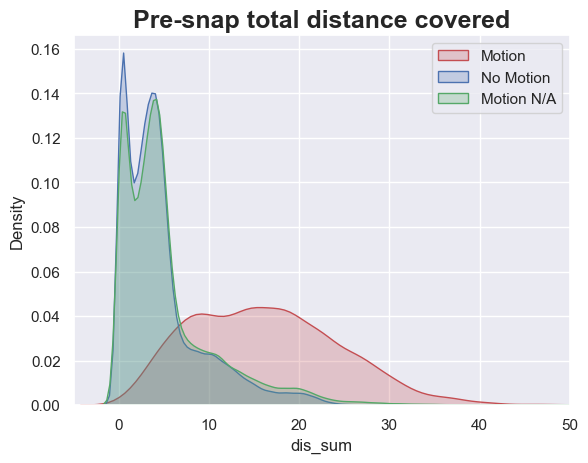

In [9]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()
sns.kdeplot(merge_dropped[merge_dropped['motionSinceLineset']]['dis_sum'], fill=True, color="r",label='Motion')
sns.kdeplot(merge_dropped[~merge_dropped['motionSinceLineset']]['dis_sum'], fill=True, color="b",label='No Motion')
sns.kdeplot(og_merge[og_merge['motionSinceLineset'].isna()]['dis_sum'], fill=True, color="g",label='Motion N/A')
ax.set_xlim(-5, 50)
plt.title('Pre-snap total distance covered',weight='bold',size=18)
ax.legend()
plt.show()

While some in-motion players don't waste steps, many still cover more ground than a direct a-to-b path requires:

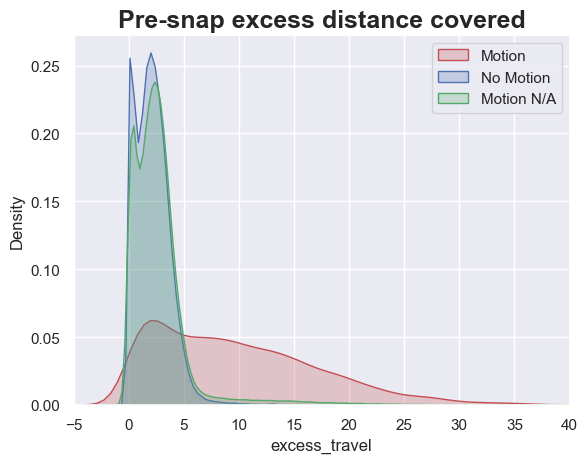

In [10]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()
sns.kdeplot(merge_dropped[merge_dropped['motionSinceLineset']]['excess_travel'], fill=True, color="r",label='Motion')
sns.kdeplot(merge_dropped[~merge_dropped['motionSinceLineset']]['excess_travel'], fill=True, color="b",label='No Motion')
sns.kdeplot(og_merge[og_merge['motionSinceLineset'].isna()]['excess_travel'], fill=True, color="g",label='Motion N/A')
ax.legend()
plt.title('Pre-snap excess distance covered',weight='bold',size=18)
ax.set_xlim(-5, 40)
plt.show()

We begin to see that, like the competition host said, the 'N/A' records are likely just non-motion frames, too:

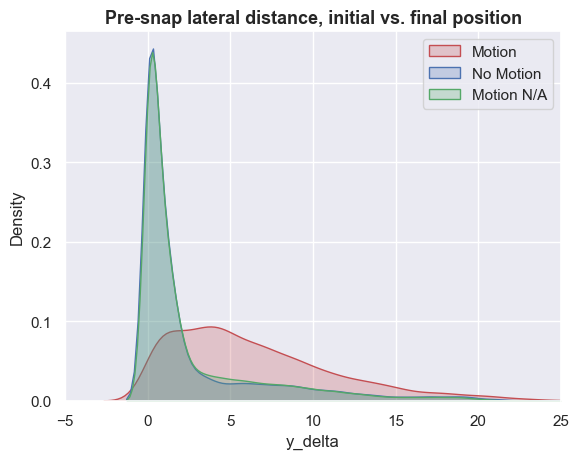

In [11]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots()
sns.kdeplot(merge_dropped[merge_dropped['motionSinceLineset']]['y_delta'], fill=True, color="r",label='Motion')
sns.kdeplot(merge_dropped[~merge_dropped['motionSinceLineset']]['y_delta'], fill=True, color="b",label='No Motion')
sns.kdeplot(og_merge[og_merge['motionSinceLineset'].isna()]['y_delta'], fill=True, color="g",label='Motion N/A')
ax.legend()
plt.title('Pre-snap lateral distance, initial vs. final position',weight='bold',size=13)
ax.set_xlim(-5, 25)
plt.show()

### Explore quantiles

Below we explore quantiles for each group. This further confirms the notion that N/A's are likely also non-motion frames.

Motion:

In [12]:
merge_dropped[merge_dropped['motionSinceLineset']][['dis_sum','excess_travel','y_delta']].quantile([.1,.25, .5,.75,.9])

,dis_sum,excess_travel,y_delta
0.10,5.980,1.34,0.950
0.25,9.725,3.59,2.660
0.50,15.740,8.64,5.340
0.75,21.875,14.49,9.110
0.90,27.340,20.01,13.386


No motion:

In [13]:
merge_dropped[~merge_dropped['motionSinceLineset']][['dis_sum','excess_travel','y_delta']].quantile([.1,.25, .5,.75,.9])

,dis_sum,excess_travel,y_delta
0.10,0.34,0.26,0.04
0.25,1.46,0.97,0.14
0.50,3.62,2.04,0.75
0.75,5.73,3.09,2.39
0.90,11.22,4.08,8.54


NA records:

In [14]:
og_merge[og_merge['motionSinceLineset'].isna()][['dis_sum','excess_travel','y_delta']].quantile([.1,.25, .5,.75,.9])

,dis_sum,excess_travel,y_delta
0.10,0.40,0.30,0.04
0.25,1.74,1.13,0.16
0.50,3.97,2.31,0.79
0.75,6.63,3.42,2.91
0.90,12.88,4.72,8.62


### Explore motion, pass rate correlations

We aggregate to play level, then see how each of our features relate to pass & motion rates:


In [15]:
motion_play = og_merge.groupby(['gameId','playId']).max().reset_index()

Add in flag for pass:

In [16]:
motion_db = motion_play.merge(df_plays[['gameId','playId','isDropback']],how='left').drop(columns=['motionSinceLineset'])

Flag if motion occurred on a play, then integrate:

In [17]:
# get play-level num. of players in motion
og_filled = og_merge.fillna(0)
motion_fill_group = og_filled.groupby(['gameId','playId'])['motionSinceLineset'].any().reset_index()
motion_fill_group['motionSinceLineset'] = motion_fill_group['motionSinceLineset'].astype(int)

# merge back in
motion_comp = motion_db.merge(motion_fill_group,how='left',on=['gameId','playId'])

First we look at correlations between our features and plays where passess occurred:

In [18]:
motion_comp.iloc[:,3:].corr()['isDropback']

y_initial             0.073048
y_final               0.244399
dis_sum               0.052443
y_delta               0.108357
excess_travel        -0.045314
isDropback            1.000000
motionSinceLineset    0.188329
Name: isDropback, dtype: float64

Then, we look at the relationship with whether any player went in motion on a play:

In [19]:
motion_comp.iloc[:,3:].corr()['motionSinceLineset']

y_initial            -0.083701
y_final              -0.041759
dis_sum               0.272806
y_delta               0.138238
excess_travel         0.311510
isDropback            0.188329
motionSinceLineset    1.000000
Name: motionSinceLineset, dtype: float64

We now examine pass-rate correlation on motion plays only:

In [20]:
motion_comp[motion_comp['motionSinceLineset'] > 0].iloc[:,3:].corr()['isDropback']

y_initial            -0.016472
y_final               0.148174
dis_sum               0.115739
y_delta               0.152297
excess_travel         0.022044
isDropback            1.000000
motionSinceLineset         NaN
Name: isDropback, dtype: float64

And now, non-motion plays:

In [21]:
motion_comp[motion_comp['motionSinceLineset'] == 0].iloc[:,3:].corr()['isDropback']

y_initial             0.126785
y_final               0.297379
dis_sum              -0.040011
y_delta               0.063138
excess_travel        -0.176061
isDropback            1.000000
motionSinceLineset         NaN
Name: isDropback, dtype: float64

Similarly, only looking at pass plays this time, we look at the correlation w/motion:

In [22]:
motion_comp[motion_comp['isDropback']].iloc[:,3:].corr()['motionSinceLineset']

y_initial            -0.145817
y_final              -0.151401
dis_sum               0.325321
y_delta               0.148570
excess_travel         0.402055
isDropback                 NaN
motionSinceLineset    1.000000
Name: motionSinceLineset, dtype: float64

Repeat for runs and motion rates:

In [23]:
motion_comp[~motion_comp['isDropback']].iloc[:,3:].corr()['motionSinceLineset']

y_initial            -0.005648
y_final              -0.001508
dis_sum               0.155215
y_delta               0.064212
excess_travel         0.187548
isDropback                 NaN
motionSinceLineset    1.000000
Name: motionSinceLineset, dtype: float64

### Explore numbers of players in motion vs. our new stats

Our best new stat is 'y_delta'; combining this with the our best motion feature (# of players in motion) might add value:

In [24]:
motion_count_df = og_filled.groupby(['gameId','playId'])['motionSinceLineset'].sum().reset_index()
motion_counted = motion_db.merge(motion_count_df,how='left',on=['gameId','playId'])

In [25]:
motion_db

,gameId,playId,nflId,y_initial,y_final,dis_sum,y_delta,excess_travel,isDropback
0,2022090800,56,53522,32.70,43.65,29.15,19.84,13.59,True
1,2022090800,80,53522,39.42,37.16,14.13,8.40,5.73,True
2,2022090800,101,53522,31.53,39.50,10.77,9.05,5.36,False
3,2022090800,122,53522,32.31,37.72,16.05,14.36,3.03,True
4,2022090800,167,53522,28.08,42.48,15.49,14.40,3.45,True
...,...,...,...,...,...,...,...,...,...
16081,2022110700,3658,54604,32.44,42.54,22.09,20.03,4.06,False
16082,2022110700,3686,54604,29.08,31.61,7.38,3.12,4.85,False
16083,2022110700,3707,54604,33.10,42.35,10.80,9.25,4.32,False
16084,2022110700,3740,54604,31.22,34.53,19.64,9.02,13.36,False


We create 'sum_all_delta', i.e., the # of players in motion times the highest 'y_delta' value on a play:

In [26]:
motion_counted['motionSinceLineset'] = motion_counted['motionSinceLineset'].astype(float)
motion_counted['sum_all_delta'] = motion_counted['motionSinceLineset']*motion_counted['y_delta']
motion_counted['pass'] = motion_counted['isDropback']
motion_counted.drop(columns=['isDropback'],inplace=True)

We see a minor value add; however, this should be tested in practice to prove its use:

In [27]:
motion_counted.iloc[:,3:].corr()['pass']

y_initial             0.073048
y_final               0.244399
dis_sum               0.052443
y_delta               0.108357
excess_travel        -0.045314
motionSinceLineset    0.172913
sum_all_delta         0.179704
pass                  1.000000
Name: pass, dtype: float64

### Calc sum stats, and not max

Same process, but with sum, and not max player stats:

In [28]:
play_sum_df = og_merge.groupby(['gameId','playId']).sum().reset_index()

In [29]:
play_merge = play_sum_df.merge(motion_count_df,how='left',on=['gameId','playId'])

In [30]:
play_sum_pass = play_merge.merge(df_plays[['gameId','playId','isDropback']],how='left')

In [31]:
play_sum_pass['motionSinceLineset'] = play_sum_pass['motionSinceLineset'].astype(int)
play_sum_pass['sum_all_delta'] = play_sum_pass['motionSinceLineset']*play_sum_pass['y_delta']

In [32]:
play_sum_pass.corr()['isDropback']

gameId               -0.022265
playId                0.013461
nflId                -0.050438
y_initial             0.003273
y_final               0.002989
dis_sum               0.051689
y_delta               0.158800
excess_travel        -0.063660
motionSinceLineset    0.172913
isDropback            1.000000
sum_all_delta         0.186483
Name: isDropback, dtype: float64

In [33]:
play_sum_pass.corr()['motionSinceLineset']

gameId               -0.144405
playId               -0.118317
nflId                 0.012378
y_initial             0.008373
y_final               0.012029
dis_sum               0.209150
y_delta               0.114773
excess_travel         0.252656
motionSinceLineset    1.000000
isDropback            0.172913
sum_all_delta         0.877117
Name: motionSinceLineset, dtype: float64

### Write out info:

In [34]:
play_sum_pass[['gameId','playId','y_delta','sum_all_delta','motionSinceLineset']].to_csv('data/motion_y_delta.csv',index=False)